<a href="https://colab.research.google.com/github/yasinsoylu1997/TEZZ2/blob/main/Xception_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import Xception
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
#!pip install visualkeras
#!pip install catboost

In [3]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [4]:
X = []
y = []
image_size = 75
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:12<00:00, 110.70it/s]


In [6]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomOverSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,75,75,3)
oversampled_y

array(['Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', ...,
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia'],
      dtype='<U15')

In [7]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

In [8]:
train_images=train_images[:1500]
test_images=test_images[:1500]
train_labels=train_labels[:1500]
test_labels=test_labels[:1500]

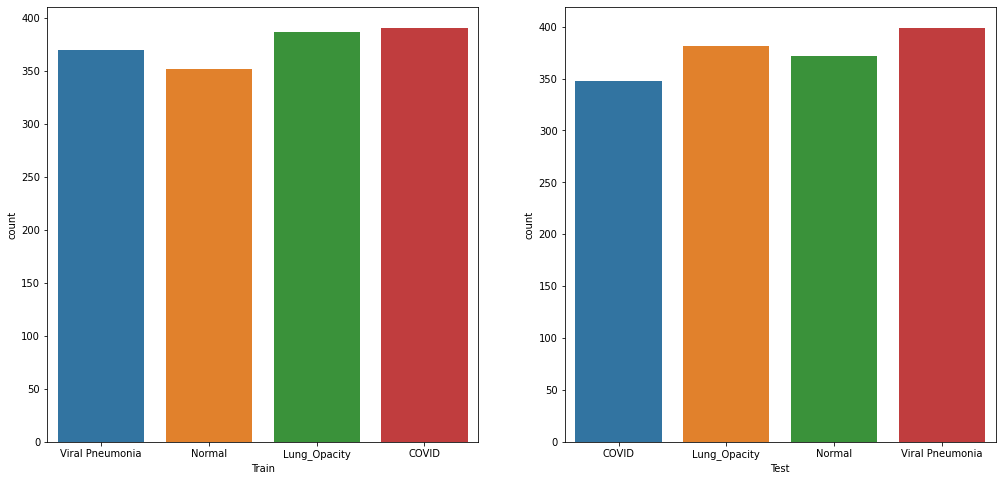

In [9]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [10]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [12]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [13]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [14]:
y_test_one_hot

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [16]:
#Load model wothout classifier/fully connected layers
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in Xception_model.layers:
	layer.trainable = False
    
Xception_model.summary()  #Trainable parameters will be 0

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 37, 37, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activat

In [17]:
#Now, let us use features from convolutional network for RF
feature_extractor=Xception_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_model= features #This is our X input to RF

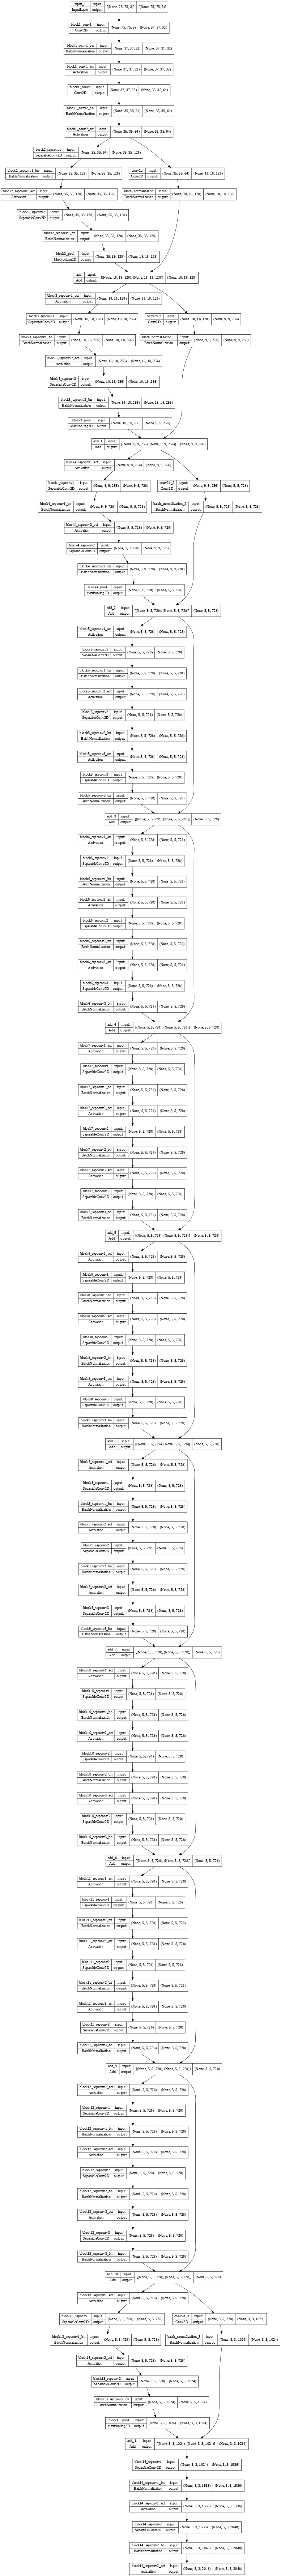

In [18]:
from keras.utils.vis_utils import plot_model

plot_model(Xception_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=50)

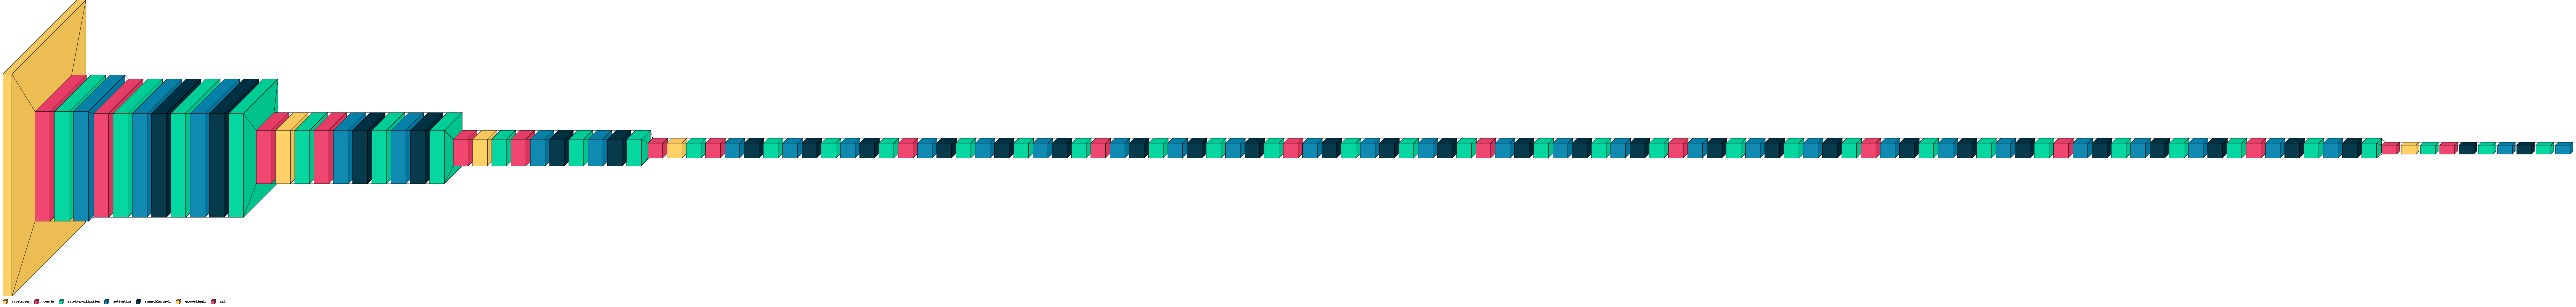

<Figure size 144x144 with 0 Axes>

In [20]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(Xception_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [21]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

In [ ]:
asdasdas

# knn

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [23]:
X_test_feature = Xception_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = knn_model.predict(X_test_features)

In [24]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.44466666666666665
MSE: 0.694
RMSE: 0.8330666239863411
R2 Square 0.4419858229020598
Accuracy 0.6733333333333333
__________________________________


In [25]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, prediction) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.444667,0.694,0.833067,0.441986,0.673333


In [26]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.54      0.53      0.54       348
           1       0.60      0.59      0.60       381
           2       0.64      0.63      0.64       372
           3       0.87      0.91      0.89       399

    accuracy                           0.67      1500
   macro avg       0.66      0.67      0.67      1500
weighted avg       0.67      0.67      0.67      1500



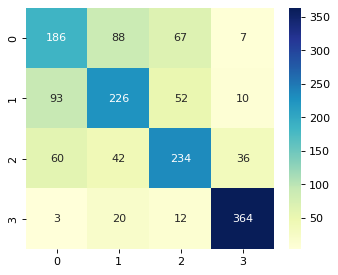

In [27]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SVC

In [28]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [29]:
X_test_feature = Xception_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svm_model.predict(X_test_features)

In [30]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.4086666666666667
MSE: 0.6566666666666666
RMSE: 0.8103497187428812
R2 Square 0.47200387661722276
Accuracy 0.7073333333333334
__________________________________


In [31]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.444667,0.694000,0.833067,0.441986,0.673333
1,SVC,0.408667,0.656667,0.810350,0.472004,0.707333


In [32]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.56      0.60      0.58       348
           1       0.65      0.69      0.67       381
           2       0.68      0.61      0.64       372
           3       0.93      0.91      0.92       399

    accuracy                           0.71      1500
   macro avg       0.70      0.70      0.70      1500
weighted avg       0.71      0.71      0.71      1500



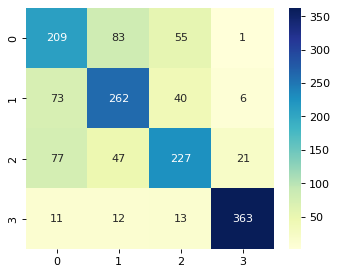

In [33]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RBF SVC

In [34]:
from sklearn.svm import SVC

svc_model = SVC(kernel = "rbf").fit(X_for_model, y_train)
svc_model = svc_model.fit(X_for_model, y_train)
svc_model

SVC()

In [35]:
X_test_feature = Xception_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svc_model.predict(X_test_features)

In [36]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.38
MSE: 0.5693333333333334
RMSE: 0.7545418035691153
R2 Square 0.5422246808437647
Accuracy 0.7113333333333334
__________________________________


In [37]:
results_df_2 = pd.DataFrame(data=[["RBF SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.444667,0.694000,0.833067,0.441986,0.673333
1,SVC,0.408667,0.656667,0.810350,0.472004,0.707333
2,RBF SVC,0.380000,0.569333,0.754542,0.542225,0.711333


In [38]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.63      0.57      0.60       348
           1       0.60      0.70      0.65       381
           2       0.72      0.65      0.68       372
           3       0.88      0.91      0.90       399

    accuracy                           0.71      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.71      0.71      0.71      1500



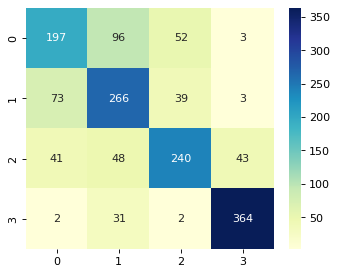

In [39]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [40]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [41]:
X_test_feature = Xception_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = cart_model.predict(X_test_features)

In [42]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.5706666666666667
MSE: 0.9613333333333334
RMSE: 0.9804760748398369
R2 Square 0.22703511683455346
Accuracy 0.6006666666666667
__________________________________


In [43]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.444667,0.694000,0.833067,0.441986,0.673333
1,SVC,0.408667,0.656667,0.810350,0.472004,0.707333
2,RBF SVC,0.380000,0.569333,0.754542,0.542225,0.711333
3,DecisionTreeClassifier,0.570667,0.961333,0.980476,0.227035,0.600667


In [44]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.49      0.51      0.50       348
           1       0.55      0.52      0.54       381
           2       0.57      0.57      0.57       372
           3       0.78      0.78      0.78       399

    accuracy                           0.60      1500
   macro avg       0.60      0.60      0.60      1500
weighted avg       0.60      0.60      0.60      1500



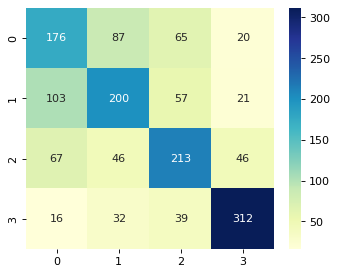

In [45]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [46]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [47]:
X_test_feature = Xception_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = lr_model.predict(X_test_features)

In [48]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3466666666666667
MSE: 0.532
RMSE: 0.7293833011524188
R2 Square 0.5722427345589276
Accuracy 0.744
__________________________________


In [49]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.444667,0.694000,0.833067,0.441986,0.673333
1,SVC,0.408667,0.656667,0.810350,0.472004,0.707333
2,RBF SVC,0.380000,0.569333,0.754542,0.542225,0.711333
3,DecisionTreeClassifier,0.570667,0.961333,0.980476,0.227035,0.600667
4,LogisticRegression,0.346667,0.532000,0.729383,0.572243,0.744000


In [50]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.65      0.63      0.64       348
           1       0.68      0.71      0.70       381
           2       0.70      0.66      0.68       372
           3       0.92      0.95      0.93       399

    accuracy                           0.74      1500
   macro avg       0.74      0.74      0.74      1500
weighted avg       0.74      0.74      0.74      1500



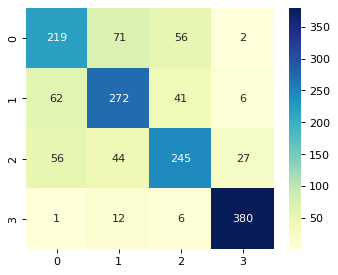

In [51]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [52]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [53]:
X_test_feature = Xception_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = SGD_model.predict(X_test_features)

In [54]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.37666666666666665
MSE: 0.598
RMSE: 0.7733045971672482
R2 Square 0.5191751038839074
Accuracy 0.73
__________________________________


In [55]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.444667,0.694000,0.833067,0.441986,0.673333
1,SVC,0.408667,0.656667,0.810350,0.472004,0.707333
2,RBF SVC,0.380000,0.569333,0.754542,0.542225,0.711333
3,DecisionTreeClassifier,0.570667,0.961333,0.980476,0.227035,0.600667
4,LogisticRegression,0.346667,0.532000,0.729383,0.572243,0.744000
5,SGDClassifier,0.376667,0.598000,0.773305,0.519175,0.730000


In [56]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.58      0.68      0.63       348
           1       0.75      0.60      0.66       381
           2       0.67      0.66      0.67       372
           3       0.91      0.96      0.94       399

    accuracy                           0.73      1500
   macro avg       0.73      0.73      0.72      1500
weighted avg       0.73      0.73      0.73      1500



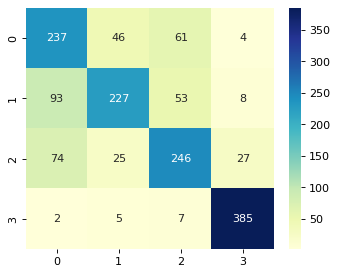

In [57]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GradientBoostingClassifier

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_model = GradientBoostingClassifier()
GBC_model = GBC_model.fit(X_for_model, y_train)
GBC_model

GradientBoostingClassifier()

In [59]:
X_test_feature = Xception_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GBC_model.predict(X_test_features)

In [60]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.376
MSE: 0.5986666666666667
RMSE: 0.7737355275975549
R2 Square 0.5186390672104224
Accuracy 0.724
__________________________________


In [61]:
results_df_2 = pd.DataFrame(data=[["GradientBoostingClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.444667,0.694000,0.833067,0.441986,0.673333
1,SVC,0.408667,0.656667,0.810350,0.472004,0.707333
2,RBF SVC,0.380000,0.569333,0.754542,0.542225,0.711333
3,DecisionTreeClassifier,0.570667,0.961333,0.980476,0.227035,0.600667
4,LogisticRegression,0.346667,0.532000,0.729383,0.572243,0.744000
5,SGDClassifier,0.376667,0.598000,0.773305,0.519175,0.730000
6,GradientBoostingClassifier,0.376000,0.598667,0.773736,0.518639,0.724000


In [62]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       348
           1       0.66      0.69      0.68       381
           2       0.69      0.67      0.68       372
           3       0.88      0.90      0.89       399

    accuracy                           0.72      1500
   macro avg       0.72      0.72      0.72      1500
weighted avg       0.72      0.72      0.72      1500



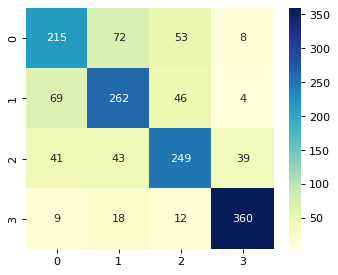

In [63]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [64]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [65]:
X_test_feature = Xception_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = LGBM_model.predict(X_test_features)

In [66]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.378
MSE: 0.6166666666666667
RMSE: 0.7852812659593165
R2 Square 0.5041660770263259
Accuracy 0.7293333333333333
__________________________________


In [67]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.444667,0.694000,0.833067,0.441986,0.673333
1,SVC,0.408667,0.656667,0.810350,0.472004,0.707333
2,RBF SVC,0.380000,0.569333,0.754542,0.542225,0.711333
3,DecisionTreeClassifier,0.570667,0.961333,0.980476,0.227035,0.600667
4,LogisticRegression,0.346667,0.532000,0.729383,0.572243,0.744000
5,SGDClassifier,0.376667,0.598000,0.773305,0.519175,0.730000
6,GradientBoostingClassifier,0.376000,0.598667,0.773736,0.518639,0.724000
7,LGBMClassifier,0.378000,0.616667,0.785281,0.504166,0.729333


In [68]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63       348
           1       0.68      0.69      0.68       381
           2       0.70      0.67      0.69       372
           3       0.86      0.92      0.89       399

    accuracy                           0.73      1500
   macro avg       0.72      0.72      0.72      1500
weighted avg       0.73      0.73      0.73      1500



# XGBClassifier

In [69]:
from xgboost.sklearn import XGBClassifier

XGBC_model = XGBClassifier()
XGBC_model = XGBC_model.fit(X_for_model, y_train)
XGBC_model

XGBClassifier(objective='multi:softprob')

In [70]:
X_test_feature = Xception_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = XGBC_model.predict(X_test_features)

In [71]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.37533333333333335
MSE: 0.6086666666666667
RMSE: 0.7801709214439274
R2 Square 0.5105985171081466
Accuracy 0.7293333333333333
__________________________________


In [72]:
results_df_2 = pd.DataFrame(data=[["XGBClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.444667,0.694000,0.833067,0.441986,0.673333
1,SVC,0.408667,0.656667,0.810350,0.472004,0.707333
2,RBF SVC,0.380000,0.569333,0.754542,0.542225,0.711333
3,DecisionTreeClassifier,0.570667,0.961333,0.980476,0.227035,0.600667
4,LogisticRegression,0.346667,0.532000,0.729383,0.572243,0.744000
5,SGDClassifier,0.376667,0.598000,0.773305,0.519175,0.730000
6,GradientBoostingClassifier,0.376000,0.598667,0.773736,0.518639,0.724000
7,LGBMClassifier,0.378000,0.616667,0.785281,0.504166,0.729333
8,XGBClassifier,0.375333,0.608667,0.780171,0.510599,0.729333


In [73]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.63      0.62      0.63       348
           1       0.68      0.68      0.68       381
           2       0.71      0.68      0.69       372
           3       0.88      0.91      0.90       399

    accuracy                           0.73      1500
   macro avg       0.72      0.72      0.72      1500
weighted avg       0.73      0.73      0.73      1500



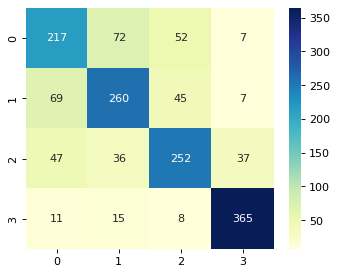

In [74]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [75]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [76]:
X_test_feature = Xception_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = rf_model.predict(X_test_features)

In [77]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3913333333333333
MSE: 0.6273333333333333
RMSE: 0.7920437698343024
R2 Square 0.4955894902505651
Accuracy 0.7173333333333334
__________________________________


In [78]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.444667,0.694000,0.833067,0.441986,0.673333
1,SVC,0.408667,0.656667,0.810350,0.472004,0.707333
2,RBF SVC,0.380000,0.569333,0.754542,0.542225,0.711333
3,DecisionTreeClassifier,0.570667,0.961333,0.980476,0.227035,0.600667
4,LogisticRegression,0.346667,0.532000,0.729383,0.572243,0.744000
5,SGDClassifier,0.376667,0.598000,0.773305,0.519175,0.730000
6,GradientBoostingClassifier,0.376000,0.598667,0.773736,0.518639,0.724000
7,LGBMClassifier,0.378000,0.616667,0.785281,0.504166,0.729333
8,XGBClassifier,0.375333,0.608667,0.780171,0.510599,0.729333
9,RandomForestClassifier,0.391333,0.627333,0.792044,0.495589,0.717333


In [79]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.62      0.61      0.62       348
           1       0.65      0.68      0.66       381
           2       0.72      0.64      0.68       372
           3       0.86      0.92      0.89       399

    accuracy                           0.72      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.72      0.72      0.72      1500



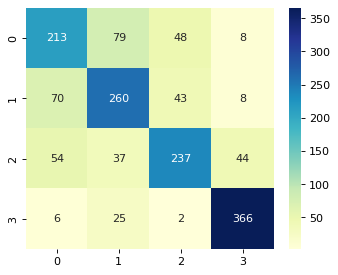

In [80]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [81]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [82]:
X_test_feature = Xception_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GB_model.predict(X_test_features)

In [83]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.6326666666666667
MSE: 1.0166666666666666
RMSE: 1.0082988974836116
R2 Square 0.18254407293529407
Accuracy 0.5426666666666666
__________________________________


In [84]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.444667,0.694000,0.833067,0.441986,0.673333
1,SVC,0.408667,0.656667,0.810350,0.472004,0.707333
2,RBF SVC,0.380000,0.569333,0.754542,0.542225,0.711333
3,DecisionTreeClassifier,0.570667,0.961333,0.980476,0.227035,0.600667
4,LogisticRegression,0.346667,0.532000,0.729383,0.572243,0.744000
5,SGDClassifier,0.376667,0.598000,0.773305,0.519175,0.730000
6,GradientBoostingClassifier,0.376000,0.598667,0.773736,0.518639,0.724000
7,LGBMClassifier,0.378000,0.616667,0.785281,0.504166,0.729333
8,XGBClassifier,0.375333,0.608667,0.780171,0.510599,0.729333
9,RandomForestClassifier,0.391333,0.627333,0.792044,0.495589,0.717333


In [85]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.49      0.29      0.37       348
           1       0.56      0.56      0.56       381
           2       0.43      0.75      0.55       372
           3       0.82      0.55      0.66       399

    accuracy                           0.54      1500
   macro avg       0.58      0.54      0.53      1500
weighted avg       0.58      0.54      0.54      1500



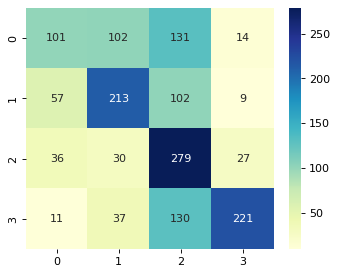

In [86]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [87]:
modeller = [rf_model,GB_model,XGBC_model,LGBM_model,GBC_model,SGD_model,lr_model,cart_model,svc_model,svm_model,knn_model]

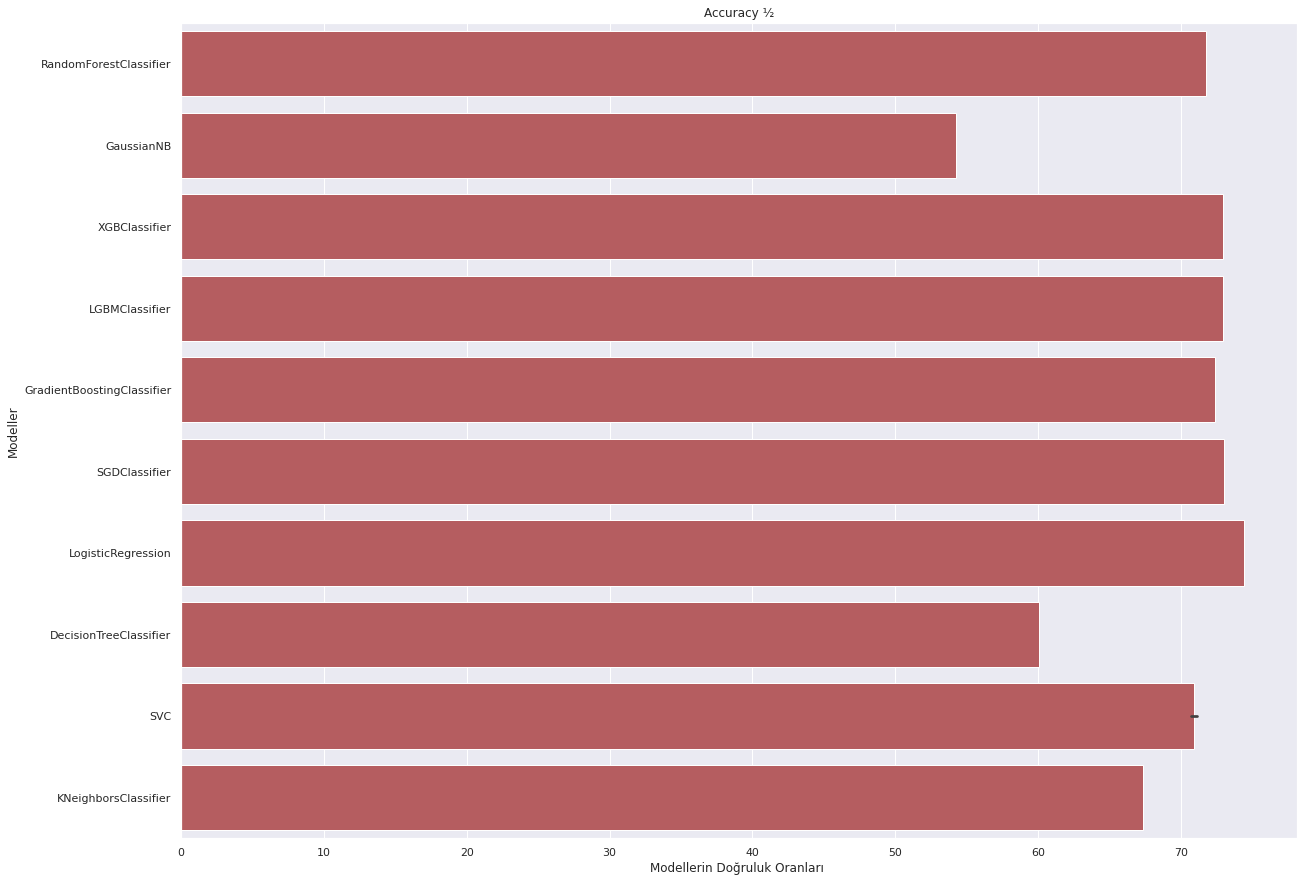

In [88]:
sonuc = []
from sklearn.metrics import accuracy_score

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_features)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy"])
    sonuclar = sonuclar.append(sonuc)
    
sns.set(rc={'figure.figsize':(20,15)})
sns.barplot(x= 'Accuracy', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('Modellerin Doğruluk Oranları ')
plt.title('Accuracy ½'); 

In [89]:
results_df


,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.444667,0.694000,0.833067,0.441986,0.673333
1,SVC,0.408667,0.656667,0.810350,0.472004,0.707333
2,RBF SVC,0.380000,0.569333,0.754542,0.542225,0.711333
3,DecisionTreeClassifier,0.570667,0.961333,0.980476,0.227035,0.600667
4,LogisticRegression,0.346667,0.532000,0.729383,0.572243,0.744000
5,SGDClassifier,0.376667,0.598000,0.773305,0.519175,0.730000
6,GradientBoostingClassifier,0.376000,0.598667,0.773736,0.518639,0.724000
7,LGBMClassifier,0.378000,0.616667,0.785281,0.504166,0.729333
8,XGBClassifier,0.375333,0.608667,0.780171,0.510599,0.729333
9,RandomForestClassifier,0.391333,0.627333,0.792044,0.495589,0.717333


In [90]:
from google.colab import files

results_df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>